In [2]:
from dtw import dtw
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import style
#style.use("gunplot")
from sklearn.cluster import KMeans
%matplotlib inline
from osgeo import gdal
from sklearn.externals import joblib
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import time as t
import math

In [3]:
def graph(x, y):
    files = ["/home/faizan/Pakistan/EVI/2010/sindh.2010%03d"  % (i) + ".tif" for i in range(1, 363) ]
    ds = gdal.Open(files[0])
    evi = np.array([ds.ReadAsArray()[(x, y)]])
    for i in files[1:]:
        ds = gdal.Open(i)
        evi = np.vstack([evi, ds.ReadAsArray()[(x, y)]])
    #plt.plot(range(91, len(evi)+91), evi / 10000.)
    plt.plot(range(0, len(evi)), evi / 10000.)
    plt.show()

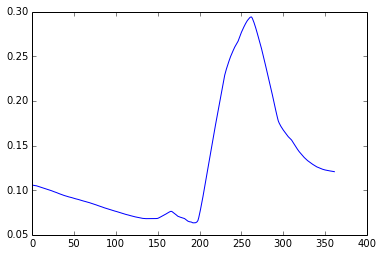

In [4]:
x, y = (687, 693)
graph(x, y)

In [5]:
EVI_path= "/home/faizan/HDD1/EVI/CSV/Pak_crop_all_point_evi.csv"
data1 = pd.read_csv(EVI_path)
data = data1[data1["ID"] == 17]
dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
data.index = dates
dummy = data[data.index.year > 2008]
dummy = dummy[dummy.index.year < 2010]
dummy = dummy[dummy.index.month > 5]
time = dummy.index
evi  = dummy["EVI"]
time1=dummy["DATE"]

data = data1[data1["ID"] == 18]
dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
data.index = dates
dummy = data[data.index.year > 2008]
dummy = dummy[dummy.index.year < 2010]
dummy = dummy[dummy.index.month > 5]
time = dummy.index
evi2  = dummy["EVI"]
time2=dummy["DATE"]

data = data1[data1["ID"] == 4]
dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
data.index = dates
dummy = data[data.index.year > 2008]
dummy = dummy[dummy.index.year < 2010]
dummy = dummy[dummy.index.month > 5]
time = dummy.index
evi3  = dummy["EVI"]
time3=dummy["DATE"]

In [6]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [7]:
print euclid_dist(evi,evi2)

12727.2726065


In [8]:
print euclid_dist(evi,evi3)

26396.9956245


In [9]:
print euclid_dist(evi2,evi3)

19748.9908603


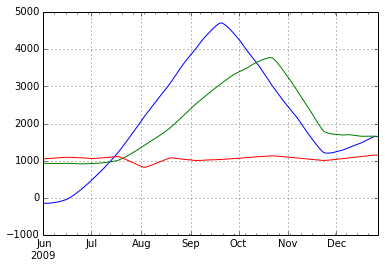

In [10]:
evi.plot()
evi2.plot()
evi3.plot()

In [11]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [12]:
print DTWDistance(evi,evi2)

6590.8698212


In [13]:
print DTWDistance(evi,evi3)

25298.7572817


In [14]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [15]:
print DTWDistance(evi,evi2,10)

9940.33892782


In [16]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [17]:
print LB_Keogh(evi,evi2,30)

6949.1490846


In [18]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        print ind
        print min_dist
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [21]:
E = np.vstack((evi, evi2))
T = np.vstack((evi2, evi3))

In [22]:
print knn(E,T,4)

0
inf
1
inf
             precision    recall  f1-score   support

     1153.0       0.00      0.00      0.00         1
     1648.0       0.50      1.00      0.67         1

avg / total       0.25      0.50      0.33         2



/usr/lib/python2.7/dist-packages/sklearn/metrics/metrics.py:1905: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [ 1153.]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [ 1153.]. 
  average=None)


In [94]:
E[:,-1]

array([ 1655.,  1648.])

#K_mean cluster

In [24]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            #print assignments
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

1
2
3
4
5
6
7
8
9
10


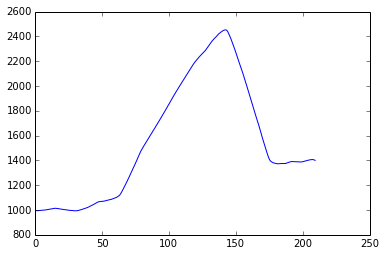

In [25]:
#train = np.genfromtxt('datasets/train.csv', delimiter='\t')
#test = np.genfromtxt('datasets/test.csv', delimiter='\t')

#train=E/10000
#test=T/10000
#data=np.vstack((train[:,:-1],test[:,:-1]))
data=np.vstack((evi,evi2,evi3))

centroids=k_means_clust(data,1,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()

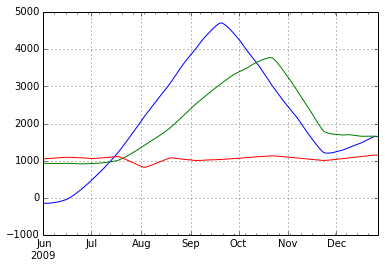

In [26]:
evi.plot()
evi2.plot()
evi3.plot()

In [27]:
centroids=k_means_clust(data,2,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()

1


TypeError: 'int' object is not iterable

In [28]:
train = np.genfromtxt('/home/faizan/Desktop/te.csv', delimiter='\t')

In [29]:
data=np.vstack((train[:,:-1],train[:,:-1]))

In [30]:
data

array([[-1.4139728 , -1.1620647 , -0.62417387, ...,  1.3630718 ,
         0.72553966, -0.88008903],
       [-1.115918  ,  0.23716141,  1.6308144 , ..., -1.3665346 ,
        -0.66266115, -1.2489139 ],
       [-1.2857446 , -0.06746462, -0.55532233, ..., -1.6829035 ,
         0.89153789,  1.5520388 ],
       ..., 
       [-0.10808234, -0.97877163, -0.55061271, ...,  0.78514926,
         0.36594352,  0.8416499 ],
       [-0.63008704, -0.5506395 ,  0.58111432, ..., -0.49145736,
        -0.96981644, -0.49904942],
       [ 0.81303753,  0.01441759,  1.2853706 , ...,  0.93264908,
         0.15278736, -0.03264544]])

1
2
3
4
5
6
7
8
9
10


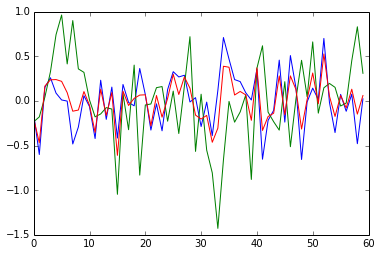

In [31]:
centroids=k_means_clust(data,3,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()